In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip


--2024-10-20 13:52:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [            <=>     ] 201.24M  56.1MB/s    in 4.4s    

2024-10-20 13:52:49 (45.6 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

0         1         2         3         4         5         6         7   \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

         8         9   ...        81         82        83        84        85  \
0 -12.23257   7.83089  ...  13.01620  -54.40548  58.99367  15.37344   1.11144   
1  -0.92019  18.76548  ...   5.66812  -19.68073  33.04964  42.87836  -9.90378   
2  -2.35035  16.07017  ...   3.03800   26.05866 -50.92779  10.93792  -0.07568   
3 -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705 -46.67617 -12.51516   
4  -9.37636  12.63699  ...   9.92661  -55.95724  64.92712 -17.72522  -1.49237   

         86         87        88         89        90  
0 -23.08793   68.40795  -1.82223  -27.46348   2.26327  
1 -32.22788   70.49388  12.04941   58.43453  26.92061  
2  43.20130 -115.00698  -0.05859   39.67068  -0.66345  
3  82.58061  -72.08993   9.90558  199.62971  18.85382  
4  -7.50035   51.76631   7.88713   55.66926  28.74903  

[5 rows x 91 columns]

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
train_size = 463715
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_train = X_scaled[:train_size, :]
Y_train = y[:train_size]
X_test = X_scaled[train_size:, :]
Y_test = y[train_size:]

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 42


In [ ]:
print(len(X_test), len(Y_test))

51630 51630


In [ ]:
model = Ridge()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
rmse_for_model = np.sqrt(mean_squared_error(Y_test, y_pred))
print("RMSE для модели:", rmse_for_model)
y_pred_mean = y_pred.mean()

y_constant_pred = np.ones(len(y_pred)) * y_pred_mean
best_rmse_metric = np.sqrt(mean_squared_error(Y_test, y_constant_pred))
print("RMSE при среднем для модели:", best_rmse_metric)

RMSE для модели: 9.510160818523268
RMSE при среднем для модели: 10.85192080596084


In [ ]:
class RDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": torch.tensor(self.y[idx], dtype=torch.float),
        }
train_dataset = RDataset(X_train, Y_train)
test_dataset = RDataset(X_test, Y_test)




In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear1 = nn.Linear(90, 1)

    def forward(self, x):
        return self.linear1(x)
def RMSE_loss(y_pred, y_true):
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))
set_random_seed(seed)
LRModel = LinearRegressionModel()
LRModel.to(device)




LinearRegressionModel(
  (linear1): Linear(in_features=90, out_features=1, bias=True)
)

In [ ]:
learning_rate = 0.03
epochs = 10
train_RMSE = []
test_RMSE = []
for epoch in range(epochs):
    train_losses = []
    for batch in tqdm(train_dataloader):
        x_train = batch['sample']
        y_train = batch['target']
        y_pred = LRModel(x_train.to(device))
        loss = RMSE_loss(y_pred, y_train.to(device))

        loss.backward()
        with torch.no_grad():
            for param in LRModel.parameters():
                param -= learning_rate * param.grad
        LRModel.zero_grad()
        train_losses.append(loss.cpu().detach().numpy())
    train_RMSE.append(np.mean(train_losses))

    test_losses = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            x_test = batch['sample']
            y_test = batch['target']
            y_pred = LRModel(x_test.to(device))

            loss = RMSE_loss(y_pred, y_test.to(device))
            test_losses.append(loss.cpu().numpy())
    test_RMSE.append(np.mean(test_losses))
    print(f"Epoch: {epoch}, Test Loss: {np.mean(test_losses)}, Train Loss: {np.mean(train_losses)}")



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 1564.215087890625, Train Loss: 1781.173095703125


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 1129.815673828125, Train Loss: 1346.44140625


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 694.9307861328125, Train Loss: 911.7252807617188


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 259.90179443359375, Train Loss: 476.6669921875


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 8.911584854125977, Train Loss: 81.68404388427734


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 8.911409378051758, Train Loss: 8.971248626708984


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 8.911408424377441, Train Loss: 8.971270561218262


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 8.911408424377441, Train Loss: 8.971270561218262


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 8.911408424377441, Train Loss: 8.971270561218262


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 8.911408424377441, Train Loss: 8.971270561218262


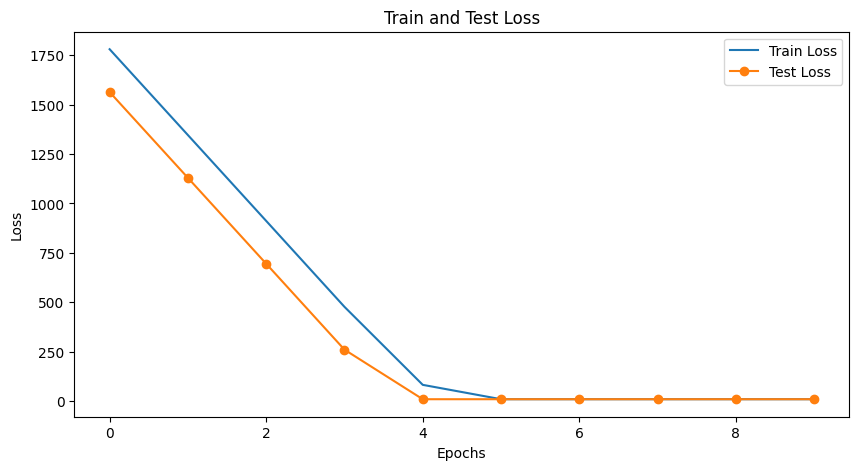

In [ ]:
epochs_range = range(epochs)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_RMSE, label="Train Loss")
plt.plot(epochs_range, test_RMSE, label="Test Loss", marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(90, 30)

        self.linear2 = nn.Linear(30, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear1(x)

        x = self.relu(x)
        x = self.linear2(x)
        return x

In [ ]:
def train(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_RMSE = []
    test_RMSE = []
    for epoch in range(epochs):
        train_losses = []
        for batch in tqdm(train_loader):
            x_train = batch['sample']
            y_train = batch['target']
            y_pred = model(x_train.to(device))
            loss = torch.sqrt(criterion(y_pred, y_train.unsqueeze(1).to(device)))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.cpu().detach().numpy())

        train_RMSE.append(np.mean(train_losses))

        test_losses = []

        with torch.no_grad():
            for batch in tqdm(test_loader):
                x_test = batch['sample']
                y_test = batch['target']
                y_pred = model(x_test.to(device))

                loss = torch.sqrt(criterion(y_pred, y_test.unsqueeze(1).to(device)))
                test_losses.append(loss.cpu().numpy())
        test_RMSE.append(np.mean(test_losses))
        print(f"Epoch: {epoch}, Test Loss: {np.mean(test_losses)}, Train Loss: {np.mean(train_losses)}")
    return train_RMSE, test_RMSE
def test(model, criterion, test_loader):
    model.eval()
    test_losses = []
    predicts = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_test = batch['sample'].to(device)
            y_test = batch['target'].to(device)
            y_pred = model(x_test)
            predicts.append(y_pred.cpu())
            loss = torch.sqrt(criterion(y_pred, y_test.unsqueeze(1).to(device)))
            test_losses.append(loss.cpu().numpy())
    print(f"RMSE для модели: {np.mean(test_losses)}")
    predicts = torch.cat(predicts, dim=0)
    return predicts

In [ ]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
train_size = 463715

X_train = X_scaled[:train_size, :]
Y_train = y_scaled[:train_size]
Y_train_not_scaled = y[:train_size]
X_test = X_scaled[train_size:, :]
Y_test_not_scaled = y[train_size:]
Y_test = y_scaled[train_size:]
train_set = RDataset(X_train, Y_train)
test_set = RDataset(X_test, Y_test)


Создание и обучение нулевой модели для второго задания.


Для нулевой модели, я выбрал простую архитектуру, два линейных слоя между ними ReLU, в качестве оптимизатора взял стохастический градиентый спуск, с learning rate = 0.006, в качестве функции потерь использовал MSE, batch_size = 64 и количество эпох равное 15

In [ ]:

set_random_seed(seed)
model0 = Model()
model0.to(device)
optimizer0 = torch.optim.SGD(model0.parameters(), lr=0.006)
criterion0 = nn.MSELoss()
test_loader0 = torch.utils.data.DataLoader(test_set, batch_size=64)
train_loader0 = torch.utils.data.DataLoader(train_set, batch_size=64)
epochs0 = 15


In [ ]:
train(model0, criterion0, optimizer0, train_loader0, test_loader0, epochs0)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.7433581352233887, Train Loss: 0.7759374380111694


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 0.7358033657073975, Train Loss: 0.7418062686920166


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 0.7328139543533325, Train Loss: 0.7366744875907898


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 0.7309920191764832, Train Loss: 0.7338728308677673


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 0.7300045490264893, Train Loss: 0.7318770289421082


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 0.729050874710083, Train Loss: 0.7302824854850769


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 0.7280442714691162, Train Loss: 0.7289409041404724


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 0.7270206809043884, Train Loss: 0.7277021408081055


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 0.7261609435081482, Train Loss: 0.7265957593917847


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 0.7255586385726929, Train Loss: 0.7255728840827942


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 10, Test Loss: 0.7248462438583374, Train Loss: 0.7246735095977783


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 11, Test Loss: 0.7242410182952881, Train Loss: 0.7238309979438782


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 12, Test Loss: 0.7237361073493958, Train Loss: 0.7230349779129028


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 13, Test Loss: 0.7229967713356018, Train Loss: 0.7222672700881958


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 14, Test Loss: 0.7223820090293884, Train Loss: 0.7215316295623779


([0.77593744,
  0.74180627,
  0.7366745,
  0.73387283,
  0.731877,
  0.7302825,
  0.7289409,
  0.72770214,
  0.72659576,
  0.7255729,
  0.7246735,
  0.723831,
  0.723035,
  0.72226727,
  0.7215316],
 [0.74335814,
  0.73580337,
  0.73281395,
  0.730992,
  0.73000455,
  0.7290509,
  0.7280443,
  0.7270207,
  0.72616094,
  0.72555864,
  0.72484624,
  0.724241,
  0.7237361,
  0.7229968,
  0.722382])

RMSE для нулевой модели составило 9.02, неплохо.

In [ ]:
test_loader0 = torch.utils.data.DataLoader(test_set)
y_pred_scaled = test(model0, criterion0, test_loader0)
predicts_inversed = scaler_y.inverse_transform(y_pred_scaled)
RMSE_model0 = np.sqrt(mean_squared_error(Y_test_not_scaled, predicts_inversed))
print("RMSE для модели после обратного скалирования таргета: ", RMSE_model0)

  0%|          | 0/51630 [00:00<?, ?it/s]

RMSE для модели: 0.5587074756622314
RMSE для модели после обратного скалирования данных:  9.02704921229856


Для следующей, первой модели я решил увеличить learning rate.

In [ ]:
set_random_seed(seed)
model1 = Model()
model1.to(device)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.007)
criterion1 = nn.MSELoss()
test_loader1 = torch.utils.data.DataLoader(test_set, batch_size = 64)
train_loader1 = torch.utils.data.DataLoader(train_set, batch_size=64)
epochs1 = 15

In [ ]:
train(model1, criterion1, optimizer1, train_loader1, test_loader1, epochs1)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.742079496383667, Train Loss: 0.7720364928245544


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 0.7352326512336731, Train Loss: 0.7406923770904541


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 0.7325208187103271, Train Loss: 0.7358555197715759


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 0.7309385538101196, Train Loss: 0.7331339716911316


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 0.7298249006271362, Train Loss: 0.7311567664146423


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 0.7285558581352234, Train Loss: 0.7295684814453125


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 0.7273771166801453, Train Loss: 0.7281521558761597


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 0.7264676690101624, Train Loss: 0.7268871665000916


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 0.7257707715034485, Train Loss: 0.7257570028305054


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 0.7251811623573303, Train Loss: 0.72475665807724


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 10, Test Loss: 0.7245202660560608, Train Loss: 0.7238282561302185


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 11, Test Loss: 0.723727822303772, Train Loss: 0.7229810953140259


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 12, Test Loss: 0.7230183482170105, Train Loss: 0.7221507430076599


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 13, Test Loss: 0.7224487066268921, Train Loss: 0.7213677167892456


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 14, Test Loss: 0.7218888998031616, Train Loss: 0.7206506133079529


([0.7720365,
  0.7406924,
  0.7358555,
  0.733134,
  0.73115677,
  0.7295685,
  0.72815216,
  0.72688717,
  0.725757,
  0.72475666,
  0.72382826,
  0.7229811,
  0.72215074,
  0.7213677,
  0.7206506],
 [0.7420795,
  0.73523265,
  0.7325208,
  0.73093855,
  0.7298249,
  0.72855586,
  0.7273771,
  0.72646767,
  0.7257708,
  0.72518116,
  0.72452027,
  0.7237278,
  0.72301835,
  0.7224487,
  0.7218889])

Здесь RMSE чуть упал, но совсем немного, попробую подбирать другой параметр. Буду немного уменьшать batch size.

In [ ]:
test_loader1 = torch.utils.data.DataLoader(test_set)
y_pred_scaled = test(model1, criterion1, test_loader1)
predicts_inversed = scaler_y.inverse_transform(y_pred_scaled)
RMSE_model1 = np.sqrt(mean_squared_error(Y_test_not_scaled, predicts_inversed))
print("RMSE для модели после обратного скалирования таргета: ", RMSE_model1)

  0%|          | 0/51630 [00:00<?, ?it/s]

RMSE для модели: 0.5582009553909302
RMSE для модели после обратного скалирования данных:  9.009341340753906


In [ ]:
set_random_seed(seed)
model2 = Model()
model2.to(device)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.006)
criterion2 = nn.MSELoss()
test_loader2 = torch.utils.data.DataLoader(test_set, batch_size=50)
train_loader2 = torch.utils.data.DataLoader(train_set, batch_size=50)
epochs2 = 15

In [ ]:
train(model2, criterion2, optimizer2, train_loader2, test_loader2, epochs2)

  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.7315220236778259, Train Loss: 0.7569882273674011


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 0.7249610424041748, Train Loss: 0.7274547219276428


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 0.7224034667015076, Train Loss: 0.7229565382003784


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 0.7206153273582458, Train Loss: 0.7203832268714905


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 0.7193044424057007, Train Loss: 0.7184609770774841


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 0.717836856842041, Train Loss: 0.716835618019104


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 0.7166074514389038, Train Loss: 0.7154026627540588


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 0.7156811356544495, Train Loss: 0.7141140699386597


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 0.7147753238677979, Train Loss: 0.7129693627357483


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 0.7138857245445251, Train Loss: 0.7119321227073669


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 10, Test Loss: 0.7129234075546265, Train Loss: 0.7109237909317017


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 11, Test Loss: 0.7121221423149109, Train Loss: 0.7099800705909729


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 12, Test Loss: 0.7113239169120789, Train Loss: 0.7090712189674377


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 13, Test Loss: 0.7107955813407898, Train Loss: 0.7082366347312927


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 14, Test Loss: 0.7101529836654663, Train Loss: 0.7074711918830872


([0.7569882,
  0.7274547,
  0.72295654,
  0.7203832,
  0.718461,
  0.7168356,
  0.71540266,
  0.71411407,
  0.71296936,
  0.7119321,
  0.7109238,
  0.7099801,
  0.7090712,
  0.70823663,
  0.7074712],
 [0.731522,
  0.72496104,
  0.72240347,
  0.7206153,
  0.71930444,
  0.71783686,
  0.71660745,
  0.71568114,
  0.7147753,
  0.7138857,
  0.7129234,
  0.71212214,
  0.7113239,
  0.7107956,
  0.710153])

Качество немного ухудшилось после уменьшения batch size.

In [ ]:
test_loader2 = torch.utils.data.DataLoader(test_set)
y_pred_scaled = test(model2, criterion2, test_loader2)
predicts_inversed = scaler_y.inverse_transform(y_pred_scaled)
RMSE_model2 = np.sqrt(mean_squared_error(Y_test_not_scaled, predicts_inversed))
print("RMSE для модели после обратного скалирования таргета: ", RMSE_model2)

  0%|          | 0/51630 [00:00<?, ?it/s]

RMSE для модели: 0.5554901361465454
RMSE для модели после обратного скалирования данных:  9.032536255381464


В следующем эксперименте я дальше немного уменьшаю параметр batch size.

In [ ]:
set_random_seed(seed)
model3 = Model()
model3.to(device)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.006)
criterion3 = nn.MSELoss()
test_loader3 = torch.utils.data.DataLoader(test_set, batch_size = 45)
train_loader3 = torch.utils.data.DataLoader(train_set, batch_size=45)
epochs3 = 15

In [ ]:
train(model3, criterion3, optimizer3, train_loader3, test_loader3, epochs3)

  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.7250961661338806, Train Loss: 0.7507135272026062


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 0.7189260721206665, Train Loss: 0.7228060960769653


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 0.716462254524231, Train Loss: 0.7184504270553589


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 0.7149629592895508, Train Loss: 0.7158570289611816


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 0.7134345769882202, Train Loss: 0.7138968706130981


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 0.7122907638549805, Train Loss: 0.7122184634208679


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 0.7112385630607605, Train Loss: 0.7107431292533875


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 0.71035236120224, Train Loss: 0.7094951868057251


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 0.7095211148262024, Train Loss: 0.7083101272583008


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 0.7087364196777344, Train Loss: 0.7071807980537415


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 10, Test Loss: 0.7078164219856262, Train Loss: 0.7061334848403931


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 11, Test Loss: 0.7071760892868042, Train Loss: 0.7051882147789001


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 12, Test Loss: 0.70671147108078, Train Loss: 0.7043220400810242


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 13, Test Loss: 0.7063184976577759, Train Loss: 0.7035394310951233


  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/1148 [00:00<?, ?it/s]

Epoch: 14, Test Loss: 0.7060796618461609, Train Loss: 0.7028355598449707


([0.7507135,
  0.7228061,
  0.7184504,
  0.715857,
  0.7138969,
  0.71221846,
  0.7107431,
  0.7094952,
  0.7083101,
  0.7071808,
  0.7061335,
  0.7051882,
  0.70432204,
  0.70353943,
  0.70283556],
 [0.72509617,
  0.7189261,
  0.71646225,
  0.71496296,
  0.7134346,
  0.71229076,
  0.71123856,
  0.71035236,
  0.7095211,
  0.7087364,
  0.7078164,
  0.7071761,
  0.7067115,
  0.7063185,
  0.70607966])

Здесь RMSE чуть-чуть упал, буду пробовать подбирать другой параметр. Попробую изменить количество эпох.

In [ ]:
test_loader3 = torch.utils.data.DataLoader(test_set)
y_pred_scaled = test(model3, criterion3, test_loader3)
predicts_inversed = scaler_y.inverse_transform(y_pred_scaled)
RMSE_model3 = np.sqrt(mean_squared_error(Y_test_not_scaled, predicts_inversed))
print("RMSE для модели после обратного скалирования таргета: ", RMSE_model3)

  0%|          | 0/51630 [00:00<?, ?it/s]

RMSE для модели: 0.556094765663147
RMSE для модели после обратного скалирования данных:  9.020535426329399


In [ ]:
set_random_seed(seed)
model4 = Model()
model4.to(device)
optimizer4 = torch.optim.SGD(model4.parameters(), lr=0.006)
criterion4 = nn.MSELoss()
test_loader4 = torch.utils.data.DataLoader(test_set, batch_size = 50)
train_loader4 = torch.utils.data.DataLoader(train_set, batch_size=50)
epochs4 = 16

In [ ]:
train(model4, criterion4, optimizer4, train_loader4, test_loader4, epochs4)

  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.7315220236778259, Train Loss: 0.7569882273674011


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 0.7249610424041748, Train Loss: 0.7274547219276428


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 0.7224034667015076, Train Loss: 0.7229565382003784


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 0.7206153273582458, Train Loss: 0.7203832268714905


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 0.7193044424057007, Train Loss: 0.7184609770774841


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 0.717836856842041, Train Loss: 0.716835618019104


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 0.7166074514389038, Train Loss: 0.7154026627540588


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 0.7156811356544495, Train Loss: 0.7141140699386597


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 0.7147753238677979, Train Loss: 0.7129693627357483


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 0.7138857245445251, Train Loss: 0.7119321227073669


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 10, Test Loss: 0.7129234075546265, Train Loss: 0.7109237909317017


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 11, Test Loss: 0.7121221423149109, Train Loss: 0.7099800705909729


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 12, Test Loss: 0.7113239169120789, Train Loss: 0.7090712189674377


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 13, Test Loss: 0.7107955813407898, Train Loss: 0.7082366347312927


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 14, Test Loss: 0.7101529836654663, Train Loss: 0.7074711918830872


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 15, Test Loss: 0.7097958326339722, Train Loss: 0.7067295908927917


([0.7569882,
  0.7274547,
  0.72295654,
  0.7203832,
  0.718461,
  0.7168356,
  0.71540266,
  0.71411407,
  0.71296936,
  0.7119321,
  0.7109238,
  0.7099801,
  0.7090712,
  0.70823663,
  0.7074712,
  0.7067296],
 [0.731522,
  0.72496104,
  0.72240347,
  0.7206153,
  0.71930444,
  0.71783686,
  0.71660745,
  0.71568114,
  0.7147753,
  0.7138857,
  0.7129234,
  0.71212214,
  0.7113239,
  0.7107956,
  0.710153,
  0.70979583])

RMSE немного уменьшился.

In [ ]:
test_loader4 = torch.utils.data.DataLoader(test_set)
y_pred_scaled = test(model4, criterion4, test_loader4)
predicts_inversed = scaler_y.inverse_transform(y_pred_scaled)
RMSE_model4 = np.sqrt(mean_squared_error(Y_test_not_scaled, predicts_inversed))
print("RMSE для модели после обратного скалирования таргета: ", RMSE_model4)

  0%|          | 0/51630 [00:00<?, ?it/s]

RMSE для модели: 0.5551052093505859
RMSE для модели после обратного скалирования данных:  9.02526110071451


In [ ]:
set_random_seed(seed)
model4_1 = Model()
model4_1.to(device)
optimizer4_1 = torch.optim.SGD(model4_1.parameters(), lr=0.006)
criterion4_1 = nn.MSELoss()
test_loader4_1 = torch.utils.data.DataLoader(test_set, batch_size = 50)
train_loader4_1 = torch.utils.data.DataLoader(train_set, batch_size=50)
epochs4_1 = 17

In [ ]:
train(model4_1, criterion4_1, optimizer4_1, train_loader4_1, test_loader4_1, epochs4_1)

  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.7315220236778259, Train Loss: 0.7569882273674011


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 0.7249610424041748, Train Loss: 0.7274547219276428


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 0.7224034667015076, Train Loss: 0.7229565382003784


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 0.7206153273582458, Train Loss: 0.7203832268714905


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 0.7193044424057007, Train Loss: 0.7184609770774841


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 0.717836856842041, Train Loss: 0.716835618019104


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 0.7166074514389038, Train Loss: 0.7154026627540588


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 0.7156811356544495, Train Loss: 0.7141140699386597


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 0.7147753238677979, Train Loss: 0.7129693627357483


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 0.7138857245445251, Train Loss: 0.7119321227073669


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 10, Test Loss: 0.7129234075546265, Train Loss: 0.7109237909317017


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 11, Test Loss: 0.7121221423149109, Train Loss: 0.7099800705909729


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 12, Test Loss: 0.7113239169120789, Train Loss: 0.7090712189674377


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 13, Test Loss: 0.7107955813407898, Train Loss: 0.7082366347312927


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 14, Test Loss: 0.7101529836654663, Train Loss: 0.7074711918830872


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 15, Test Loss: 0.7097958326339722, Train Loss: 0.7067295908927917


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 16, Test Loss: 0.7093915939331055, Train Loss: 0.7060612440109253


([0.7569882,
  0.7274547,
  0.72295654,
  0.7203832,
  0.718461,
  0.7168356,
  0.71540266,
  0.71411407,
  0.71296936,
  0.7119321,
  0.7109238,
  0.7099801,
  0.7090712,
  0.70823663,
  0.7074712,
  0.7067296,
  0.70606124],
 [0.731522,
  0.72496104,
  0.72240347,
  0.7206153,
  0.71930444,
  0.71783686,
  0.71660745,
  0.71568114,
  0.7147753,
  0.7138857,
  0.7129234,
  0.71212214,
  0.7113239,
  0.7107956,
  0.710153,
  0.70979583,
  0.7093916])

Еще совсем немного уменьшился, не вижу смысла в большем увеличении числа эпох.

In [ ]:
test_loader4_1 = torch.utils.data.DataLoader(test_set)
y_pred_scaled = test(model4_1, criterion4_1, test_loader4_1)
predicts_inversed = scaler_y.inverse_transform(y_pred_scaled)
RMSE_model4_1 = np.sqrt(mean_squared_error(Y_test_not_scaled, predicts_inversed))
print("RMSE для модели после обратного скалирования таргета: ", RMSE_model4_1)

  0%|          | 0/51630 [00:00<?, ?it/s]

RMSE для модели: 0.5545653700828552
RMSE для модели после обратного скалирования данных:  9.018771808510351


Попробую поменять критерий на другой, возьму L1Loss.

In [ ]:
set_random_seed(seed)
model5 = Model()
model5.to(device)
optimizer5 = torch.optim.SGD(model5.parameters(), lr=0.005)
criterion5 = nn.L1Loss()
test_loader5 = torch.utils.data.DataLoader(test_set, batch_size = 50)
train_loader5 = torch.utils.data.DataLoader(train_set, batch_size=50)
epochs5 = 10

In [ ]:
train(model5, criterion5, optimizer5, train_loader5, test_loader5, epochs5)

  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.7282401919364929, Train Loss: 0.7517855167388916


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 0.7209561467170715, Train Loss: 0.7232110500335693


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 0.7184575796127319, Train Loss: 0.7189334034919739


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 0.7170319557189941, Train Loss: 0.7171539068222046


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 0.7162659168243408, Train Loss: 0.7159844636917114


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 0.7156482338905334, Train Loss: 0.715107798576355


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 0.715365469455719, Train Loss: 0.7144298553466797


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 0.7149651646614075, Train Loss: 0.7138583660125732


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 0.7145881652832031, Train Loss: 0.7133845090866089


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 0.7143317461013794, Train Loss: 0.7129411697387695


([0.7517855,
  0.72321105,
  0.7189334,
  0.7171539,
  0.71598446,
  0.7151078,
  0.71442986,
  0.71385837,
  0.7133845,
  0.71294117],
 [0.7282402,
  0.72095615,
  0.7184576,
  0.71703196,
  0.7162659,
  0.71564823,
  0.71536547,
  0.71496516,
  0.71458817,
  0.71433175])

Ошибка сильно выросла.

In [ ]:
test_loader5 = torch.utils.data.DataLoader(test_set)
y_pred_scaled = test(model5, criterion5, test_loader5)
predicts_inversed = scaler_y.inverse_transform(y_pred_scaled)
RMSE_model5 = np.sqrt(mean_squared_error(Y_test_not_scaled, predicts_inversed))
print("RMSE для модели после обратного скалирования таргета: ", RMSE_model5)

  0%|          | 0/51630 [00:00<?, ?it/s]

RMSE для модели: 0.650275468826294
RMSE для модели после обратного скалирования данных:  9.503327256282207


Попробую очень сильно увеличить количество эпох.

In [ ]:
set_random_seed(seed)
model4_2 = Model()
model4_2.to(device)
optimizer4_2 = torch.optim.SGD(model4_2.parameters(), lr=0.006)
criterion4_2 = nn.MSELoss()
test_loader4_2 = torch.utils.data.DataLoader(test_set, batch_size=50)
train_loader4_2 = torch.utils.data.DataLoader(train_set, batch_size=50)
epochs4_2 = 50

In [ ]:
train(model4_2, criterion4_2, optimizer4_2, train_loader4_2, test_loader4_2, epochs4_2)

  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.7315220236778259, Train Loss: 0.7569882273674011


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 0.7249610424041748, Train Loss: 0.7274547219276428


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 0.7224034667015076, Train Loss: 0.7229565382003784


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 0.7206153273582458, Train Loss: 0.7203832268714905


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 0.7193044424057007, Train Loss: 0.7184609770774841


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 0.717836856842041, Train Loss: 0.716835618019104


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 0.7166074514389038, Train Loss: 0.7154026627540588


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 0.7156811356544495, Train Loss: 0.7141140699386597


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 0.7147753238677979, Train Loss: 0.7129693627357483


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 0.7138857245445251, Train Loss: 0.7119321227073669


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 10, Test Loss: 0.7129234075546265, Train Loss: 0.7109237909317017


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 11, Test Loss: 0.7121221423149109, Train Loss: 0.7099800705909729


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 12, Test Loss: 0.7113239169120789, Train Loss: 0.7090712189674377


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 13, Test Loss: 0.7107955813407898, Train Loss: 0.7082366347312927


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 14, Test Loss: 0.7101529836654663, Train Loss: 0.7074711918830872


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 15, Test Loss: 0.7097958326339722, Train Loss: 0.7067295908927917


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 16, Test Loss: 0.7093915939331055, Train Loss: 0.7060612440109253


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 17, Test Loss: 0.709111750125885, Train Loss: 0.7055087685585022


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 18, Test Loss: 0.7088294625282288, Train Loss: 0.7049815654754639


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 19, Test Loss: 0.7084316611289978, Train Loss: 0.7044912576675415


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 20, Test Loss: 0.7081353068351746, Train Loss: 0.7040451765060425


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 21, Test Loss: 0.7079338431358337, Train Loss: 0.7036035060882568


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 22, Test Loss: 0.7076730132102966, Train Loss: 0.7032144665718079


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 23, Test Loss: 0.707429826259613, Train Loss: 0.7028552889823914


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 24, Test Loss: 0.7072718739509583, Train Loss: 0.7025384306907654


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 25, Test Loss: 0.7071280479431152, Train Loss: 0.7022165656089783


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 26, Test Loss: 0.7069146037101746, Train Loss: 0.7019440531730652


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 27, Test Loss: 0.7067533135414124, Train Loss: 0.7016708850860596


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 28, Test Loss: 0.7066255807876587, Train Loss: 0.7014159560203552


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 29, Test Loss: 0.706459641456604, Train Loss: 0.7011794447898865


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 30, Test Loss: 0.706354022026062, Train Loss: 0.7009583115577698


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 31, Test Loss: 0.7061200141906738, Train Loss: 0.7007634043693542


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 32, Test Loss: 0.705960750579834, Train Loss: 0.7005689144134521


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 33, Test Loss: 0.7059060335159302, Train Loss: 0.7003872394561768


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 34, Test Loss: 0.7058550715446472, Train Loss: 0.700212836265564


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 35, Test Loss: 0.705830991268158, Train Loss: 0.7000557780265808


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 36, Test Loss: 0.7057024836540222, Train Loss: 0.6999115943908691


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 37, Test Loss: 0.7055888772010803, Train Loss: 0.6997778415679932


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 38, Test Loss: 0.7055683135986328, Train Loss: 0.6996479034423828


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 39, Test Loss: 0.7055333256721497, Train Loss: 0.6995266079902649


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 40, Test Loss: 0.7054414749145508, Train Loss: 0.6994178295135498


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 41, Test Loss: 0.7054198980331421, Train Loss: 0.6993050575256348


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 42, Test Loss: 0.7053832411766052, Train Loss: 0.6991947293281555


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 43, Test Loss: 0.7053500413894653, Train Loss: 0.6991019248962402


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 44, Test Loss: 0.705338180065155, Train Loss: 0.6990070939064026


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 45, Test Loss: 0.7052688598632812, Train Loss: 0.6989110708236694


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 46, Test Loss: 0.7052302956581116, Train Loss: 0.6988275051116943


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 47, Test Loss: 0.7051785588264465, Train Loss: 0.6987309455871582


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 48, Test Loss: 0.7052145004272461, Train Loss: 0.6986410617828369


  0%|          | 0/9275 [00:00<?, ?it/s]

  0%|          | 0/1033 [00:00<?, ?it/s]

Epoch: 49, Test Loss: 0.7052215933799744, Train Loss: 0.6985381841659546


([0.7569882,
  0.7274547,
  0.72295654,
  0.7203832,
  0.718461,
  0.7168356,
  0.71540266,
  0.71411407,
  0.71296936,
  0.7119321,
  0.7109238,
  0.7099801,
  0.7090712,
  0.70823663,
  0.7074712,
  0.7067296,
  0.70606124,
  0.70550877,
  0.70498157,
  0.70449126,
  0.7040452,
  0.7036035,
  0.70321447,
  0.7028553,
  0.70253843,
  0.70221657,
  0.70194405,
  0.7016709,
  0.70141596,
  0.70117944,
  0.7009583,
  0.7007634,
  0.7005689,
  0.70038724,
  0.70021284,
  0.7000558,
  0.6999116,
  0.69977784,
  0.6996479,
  0.6995266,
  0.6994178,
  0.69930506,
  0.6991947,
  0.6991019,
  0.6990071,
  0.6989111,
  0.6988275,
  0.69873095,
  0.69864106,
  0.6985382],
 [0.731522,
  0.72496104,
  0.72240347,
  0.7206153,
  0.71930444,
  0.71783686,
  0.71660745,
  0.71568114,
  0.7147753,
  0.7138857,
  0.7129234,
  0.71212214,
  0.7113239,
  0.7107956,
  0.710153,
  0.70979583,
  0.7093916,
  0.70911175,
  0.70882946,
  0.70843166,
  0.7081353,
  0.70793384,
  0.707673,
  0.7074298,
  0.7072

In [ ]:
test_loader4_2 = torch.utils.data.DataLoader(test_set)
y_pred_scaled = test(model4_2, criterion4_2, test_loader4_2)
predicts_inversed = scaler_y.inverse_transform(y_pred_scaled)
RMSE_model4_2 = np.sqrt(mean_squared_error(Y_test_not_scaled, predicts_inversed))
print("RMSE для модели после обратного скалирования таргета: ", RMSE_model4_2)


  0%|          | 0/51630 [00:00<?, ?it/s]

RMSE для модели: 0.549861490726471
RMSE для модели после обратного скалирования данных:  8.953250118249557


После многих попыток и экспериментов я решил вернуться к истокам. Взял самую простую модель из одного слоя, взял стохастический градиентный спуск с очень маленькой длиной шага и решил запустить это все на большом количестве эпох. Также решил нескалировать таргет. По идее это будет медленно, но из-за маленькой длины шага, достаточно точно.

In [ ]:
set_random_seed(seed)
model = LinearRegressionModel()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()
train_dataset = RDataset(X_train, Y_train_not_scaled)
test_dataset = RDataset(X_test, Y_test_not_scaled)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128)
epochs = 60

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 1962.33447265625, Train Loss: 1980.300537109375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 1926.170166015625, Train Loss: 1944.067626953125


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, Test Loss: 1889.99072265625, Train Loss: 1907.8284912109375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, Test Loss: 1853.820068359375, Train Loss: 1871.5892333984375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 4, Test Loss: 1817.6602783203125, Train Loss: 1835.3712158203125


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 5, Test Loss: 1781.4971923828125, Train Loss: 1799.1578369140625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 6, Test Loss: 1745.330810546875, Train Loss: 1762.9447021484375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 7, Test Loss: 1709.10986328125, Train Loss: 1726.7078857421875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 8, Test Loss: 1672.8826904296875, Train Loss: 1690.440185546875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 9, Test Loss: 1636.65283203125, Train Loss: 1654.1727294921875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 10, Test Loss: 1600.4207763671875, Train Loss: 1617.9056396484375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 11, Test Loss: 1564.186767578125, Train Loss: 1581.6387939453125


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 12, Test Loss: 1527.950439453125, Train Loss: 1545.3720703125


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 13, Test Loss: 1491.7125244140625, Train Loss: 1509.105712890625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 14, Test Loss: 1455.472900390625, Train Loss: 1472.83935546875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 15, Test Loss: 1419.2314453125, Train Loss: 1436.5732421875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 16, Test Loss: 1382.988525390625, Train Loss: 1400.3076171875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 17, Test Loss: 1346.744140625, Train Loss: 1364.0419921875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 18, Test Loss: 1310.498291015625, Train Loss: 1327.7767333984375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 19, Test Loss: 1274.2509765625, Train Loss: 1291.511474609375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 20, Test Loss: 1238.00244140625, Train Loss: 1255.2464599609375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 21, Test Loss: 1201.75244140625, Train Loss: 1218.9818115234375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 22, Test Loss: 1165.501220703125, Train Loss: 1182.7174072265625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 23, Test Loss: 1129.24853515625, Train Loss: 1146.453125


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 24, Test Loss: 1092.9947509765625, Train Loss: 1110.18896484375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 25, Test Loss: 1056.739501953125, Train Loss: 1073.9251708984375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 26, Test Loss: 1020.4829711914062, Train Loss: 1037.6617431640625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 27, Test Loss: 984.2252197265625, Train Loss: 1001.3984375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 28, Test Loss: 947.9661254882812, Train Loss: 965.1353759765625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 29, Test Loss: 911.7056274414062, Train Loss: 928.8727416992188


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 30, Test Loss: 875.44384765625, Train Loss: 892.6102905273438


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 31, Test Loss: 839.1806640625, Train Loss: 856.3482055664062


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 32, Test Loss: 802.916015625, Train Loss: 820.0863647460938


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 33, Test Loss: 766.64990234375, Train Loss: 783.8250122070312


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 34, Test Loss: 730.3824462890625, Train Loss: 747.56396484375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 35, Test Loss: 694.1134033203125, Train Loss: 711.3033447265625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 36, Test Loss: 657.8429565429688, Train Loss: 675.043212890625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 37, Test Loss: 621.57080078125, Train Loss: 638.7836303710938


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 38, Test Loss: 585.297119140625, Train Loss: 602.5244750976562


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 39, Test Loss: 549.0219116210938, Train Loss: 566.26611328125


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 40, Test Loss: 512.7449951171875, Train Loss: 530.0084228515625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 41, Test Loss: 476.46649169921875, Train Loss: 493.7517395019531


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 42, Test Loss: 440.18646240234375, Train Loss: 457.4960632324219


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 43, Test Loss: 403.9049072265625, Train Loss: 421.2417297363281


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 44, Test Loss: 367.6219787597656, Train Loss: 384.98895263671875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 45, Test Loss: 331.33795166015625, Train Loss: 348.73834228515625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 46, Test Loss: 295.05340576171875, Train Loss: 312.490478515625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 47, Test Loss: 258.7691345214844, Train Loss: 276.2466125488281


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 48, Test Loss: 222.48727416992188, Train Loss: 240.00843811035156


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 49, Test Loss: 186.21287536621094, Train Loss: 203.78030395507812


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 50, Test Loss: 149.9629364013672, Train Loss: 167.5730438232422


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 51, Test Loss: 113.78713989257812, Train Loss: 131.41842651367188


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 52, Test Loss: 77.79882049560547, Train Loss: 95.39630126953125


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 53, Test Loss: 42.467681884765625, Train Loss: 59.74891662597656


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 54, Test Loss: 12.991658210754395, Train Loss: 26.296241760253906


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 55, Test Loss: 8.774222373962402, Train Loss: 9.619921684265137


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 56, Test Loss: 8.75071907043457, Train Loss: 8.841811180114746


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 57, Test Loss: 8.747876167297363, Train Loss: 8.834183692932129


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 58, Test Loss: 8.747268676757812, Train Loss: 8.832511901855469


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 59, Test Loss: 8.747150421142578, Train Loss: 8.83199691772461


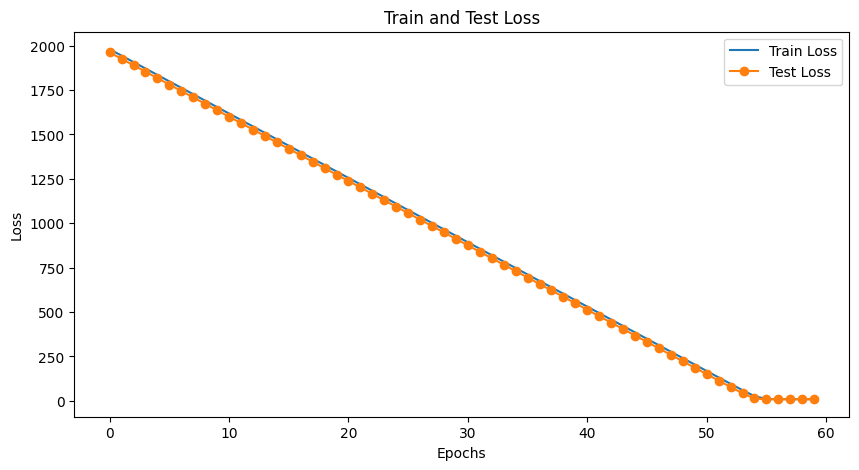

In [ ]:
train_RMSE, test_RMSE = train(model, criterion, optimizer, train_loader, test_loader, epochs)

epochs_range = range(epochs)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_RMSE, label="Train Loss")
plt.plot(epochs_range, test_RMSE, label="Test Loss", marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

В итоге я смог получить качество 8.747!

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset)
y_pred_scaled = test(model, criterion, test_loader)
RMSE_model5 = np.sqrt(mean_squared_error(Y_test, y_pred_scaled))

  0%|          | 0/51630 [00:00<?, ?it/s]

RMSE для модели: 6.62273645401001


**ОТЧЕТ**
Я использовал разные значения гиперпараметров и модели. Я обучил простую модель с двумя линейными слоями и ReLU между ними, сначала я использовал SGD и увеличивал LR, дойдя до минимального значения RMSE, я решил изменить размер батча, качество несколько раз выросло. Далее я увеличил немного количество эпох до 16 и качество опять выросло достигнув 8.96. Я решил изменить функцию потерь на L1Loss и ошибка сильно выросла. Тогда я вернулся в самое начало, взял самую простую модель, стохастический градиентный спуск, большое количество эпох. Качество получилось 8.747

In [ ]:
bins = 10
Y_train_10 = pd.cut(Y_train_not_scaled, bins=bins, labels=False)
Y_test_10 = pd.cut(Y_test_not_scaled, bins=bins, labels=False)


In [ ]:
unique_years = len(np.unique(Y_train_not_scaled))
Y_train_89 = pd.cut(Y_train_not_scaled, bins=unique_years, labels=False)
Y_test_89 = pd.cut(Y_test_not_scaled, bins=unique_years, labels=False)


In [ ]:
Y_train_10

array([8, 8, 8, ..., 9, 9, 9])

In [ ]:
train_dataset_89 = RDataset(X_train, Y_train_89)
test_dataset_89 = RDataset(X_test, Y_test_89)
train_dataset_10 = RDataset(X_train, Y_train_10)
test_dataset_10 = RDataset(X_test, Y_test_10)

In [ ]:
class Model_Classification_all(nn.Module):
    def __init__(self):
        super(Model_Classification_all, self).__init__()
        self.linear1 = nn.Linear(90, 89)
    def forward(self, x):
        return self.linear1(x)

In [ ]:
class Model_Classification_10(nn.Module):
    def __init__(self):
        super(Model_Classification_10, self).__init__()
        self.linear1 = nn.Linear(90, 10)
    def forward(self, x):
        return self.linear1(x)

In [ ]:
def train_classification(model, criterion, optimizer, train_loader, epochs):
    true_labels = []
    for epoch in range(epochs):
        train_losses = []
        for batch in tqdm(train_loader):
            x_train = batch['sample'].to(device)
            y_train = batch['target'].to(device)
            y_train = y_train.type(torch.LongTensor)
            y_pred = model(x_train.to(device))
            loss = criterion(y_pred, y_train.to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.cpu().detach().numpy())




        print(f"Epoch: {epoch}, Train Loss: {np.mean(train_losses)}")
def test_classification(model, criterion, test_loader):

    predicts = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_test = batch['sample'].to(device)
            y_test = batch['target'].to(device)

            y_pred = model(x_test)
            predicts.append(y_pred.cpu())
            true_labels.append(y_test.cpu())

    predicts = torch.cat(predicts, dim=0)
    true_labels = torch.cat(true_labels, dim=0)


    _, predicted_classes = torch.max(predicts, 1)
    print(predicts)
    print(predicted_classes.shape[0], "predicted shape")
    print(predicted_classes, "predicted")
    print(true_labels.shape[0])
    accuracy = accuracy_score(true_labels, predicted_classes)
    precision = precision_score(true_labels, predicted_classes, average='macro')
    recall = recall_score(true_labels, predicted_classes, average='macro')

    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
    return predicted_classes

In [ ]:
set_random_seed(seed)
modelC = Model_Classification_all()
modelC.to(device)
optimizerC = torch.optim.SGD(modelC.parameters(), lr=0.006)
criterionC = nn.CrossEntropyLoss()
train_loaderC = torch.utils.data.DataLoader(train_dataset_89, batch_size=50)
epochsC = 10

In [ ]:
train_classification(modelC, criterionC, optimizerC, train_loaderC, epochsC)

  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 3.916120767593384


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 3.4635117053985596


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 3.3600966930389404


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 3.314807176589966


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 3.289196014404297


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 3.2727389335632324


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 3.2612922191619873


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 3.2528793811798096


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 3.2464394569396973


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 3.2413525581359863


In [ ]:
test_loaderС = torch.utils.data.DataLoader(test_dataset_89)


In [ ]:
test_classification(modelC, criterionC, test_loaderС)

  0%|          | 0/51630 [00:00<?, ?it/s]

tensor([[-1.3213, -1.4275, -1.5393,  ...,  2.1790,  1.4187, -1.3354],
        [-1.3010, -1.3065, -1.3405,  ...,  3.9575,  2.5638, -1.2672],
        [-1.3902, -1.3659, -1.3088,  ...,  3.2780,  1.8272, -1.3135],
        ...,
        [-1.1522, -1.3792, -1.4027,  ...,  2.5801,  1.9084, -0.8892],
        [-0.7795, -1.2026, -1.0590,  ...,  3.5519,  2.4540, -0.9419],
        [-1.1451, -1.1992, -1.4941,  ...,  3.2895,  2.0658, -1.2812]])
51630 predicted shape
tensor([84, 84, 84,  ..., 84, 83, 84]) predicted
51630
Accuracy: 0.07640906449738524, Precision: 0.02202265573992413, Recall: 0.019620578963358688


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


tensor([84, 84, 84,  ..., 84, 83, 84])

In [ ]:
set_random_seed(seed)
modelC_1 = Model_Classification_10()
modelC_1.to(device)
optimizerC_1 = torch.optim.SGD(modelC_1.parameters(), lr=0.006)
criterionC_1 = nn.CrossEntropyLoss()
train_loaderC_1 = torch.utils.data.DataLoader(train_dataset_10, batch_size=50)
epochsC_1 = 10

In [ ]:
train_classification(modelC_1, criterionC_1, optimizerC_1, train_loaderC_1, epochsC_1)

  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 1.3124500513076782


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 1.1694965362548828


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 1.1575030088424683


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 1.152547836303711


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 1.1497820615768433


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 1.1479978561401367


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 1.1467446088790894


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 1.1458138227462769


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 1.1450941562652588


  0%|          | 0/9275 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 1.1445209980010986


In [ ]:
test_loaderС_1 = torch.utils.data.DataLoader(test_dataset_10)

In [ ]:
test_classification(modelC_1, criterionC_1, test_loaderС_1)

  0%|          | 0/51630 [00:00<?, ?it/s]

tensor([[-2.1990, -2.2213, -2.3765,  ...,  2.1500,  2.4969,  2.7751],
        [-1.9844, -2.2343, -2.5559,  ...,  1.7136,  3.1630,  4.5556],
        [-2.3957, -2.6044, -2.7610,  ...,  1.9887,  3.3255,  4.3096],
        ...,
        [-2.1899, -2.3078, -2.4403,  ...,  3.4090,  3.5440,  4.2736],
        [-2.9142, -2.8549, -2.7805,  ...,  1.7210,  4.0570,  5.1108],
        [-2.2013, -2.3462, -2.7555,  ...,  1.8504,  2.7603,  3.7851]])
51630 predicted shape
tensor([9, 9, 9,  ..., 9, 9, 9]) predicted
51630
Accuracy: 0.5446058493124153, Precision: 0.1949519154218561, Recall: 0.15503156939406107


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


tensor([9, 9, 9,  ..., 9, 9, 9])

В целом результаты получились достаточно логичными. Когда у нас классов целых 89 штук (количество всех годов), модели очень сложно выполнить классификацию, так как она должна уметь различать минимальные изменения в данных. Особенно если классы очень похожи, имеют очень похожие характеристики. Поэтому результатыы метрик достаточно низкие. А вот у модели, у которой всего 10 классов результаты оказались гораздо лучше. Из-за того, что задача классификации стала заметно проще (всего 10 классов вместо 89), метрики выросли. Модели теперь проще определять закономерности в классах.
Модели регрессии отличаются от моделей классификации, тем что как минимум там выдается одно предсказанное число, в классификации это будет вектор в котором будут вероятности того, что тот или иной объект попадает в этот класс. Очевидно, что у моделей также различаются функции потерь так как опять же поставлены разные задачи. И отличаюстя метрики качества.
